In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math 
import random
import copy
import cv2

In [15]:
inputImage = cv2.imread('./panamericana1.PNG')
objectiveImage = cv2.imread('./panamericana2.PNG')

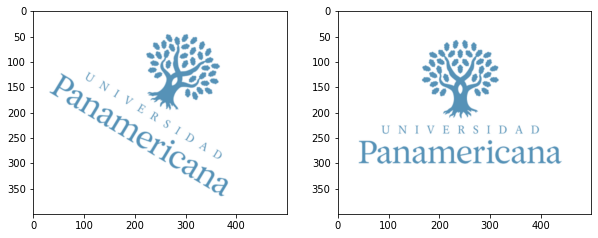

In [16]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(inputImage)
plt.subplot(1,2,2)
plt.imshow(objectiveImage)

In [17]:
def objectiveFunction(img1, img2):
    return np.sum((img1-img2)**2)

In [60]:
# Rotate Test
(h, w) = inputImage.shape[:2]
(cX, cY) = (w // 2, h // 2)
M = cv2.getRotationMatrix2D((cX, cY), 32, 1.0)
rotated = cv2.warpAffine(inputImage, M, (w, h), borderValue=(255,255,255))
cv2.imshow("Rotated by 45 Degrees", rotated)

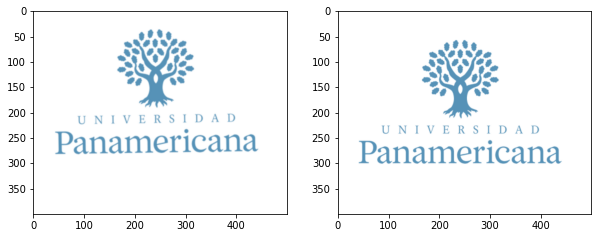

In [61]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(rotated)
plt.subplot(1,2,2)
plt.imshow(objectiveImage)

In [62]:
print(objectiveFunction(inputImage, objectiveImage))
print(objectiveFunction(rotated, objectiveImage))

10703647
9708259
